# Project: Segmentation of space objects

## 1. Problem Statmenet

You are a CV specialist at a startup, tasked with building a model to predict the trajectory of active space objects to avoid collisions with space debris. Your task is to segment images of artificial satellites and space stations, achieving an mIoU metric value of >70% on the validation set.

## 2. Import Libraries and Define Constants

In [6]:
import albumentations as A
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image
from tqdm import tqdm

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.models.segmentation import deeplabv3_resnet50
from sklearn.model_selection import train_test_split

is_debug_mode = True

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

images_dir = 'data/images/'
mask_dir = 'data/mask/'

Using device: mps


## 3. Loading Data

Define a custom dataset to load satelites data.

In [73]:
class SattDataset(Dataset):
    def __init__(self, image_dir, mask_dir, split="train", transform=None):
        self.images_filenames = os.listdir(image_dir + split) 
        self.transform = transform
        
        self.image_dir = image_dir + split
        self.mask_dir = mask_dir + split

        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )


    def __len__(self):
        return len(self.images_filenames)


    def __getitem__(self, idx):
        image_name = self.images_filenames[idx]
        mask_name = image_name.replace('.png', '_mask.png')

        image = Image.open(os.path.join(self.image_dir, image_name)).convert("RGB")
        mask  = Image.open(os.path.join(self.mask_dir, mask_name)).convert("RGB")
        
        image_np = np.array(image)
        mask_np  = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image = augmented["image"]
            mask  = augmented["mask"]

        # To Tensor
        image = TF.to_tensor(image)
        image = self.normalize(image)

        mask = TF.to_tensor(mask).squeeze(0)
        
        return image, mask

Loading datasets and defining data loaders.

For development and debugging I use Subsets of data to get results faster.

In [74]:
dataset_train = SattDataset(
    images_dir, 
    mask_dir, 
    # transform=train_transform,
    split="train"
)
if is_debug_mode:
    dataset_train = torch.utils.data.Subset(dataset_train, range(400))

dataset_val = SattDataset(
    images_dir, 
    mask_dir, 
    # transform=val_transform,
    split="val"
)
if is_debug_mode:
    dataset_val = torch.utils.data.Subset(dataset_val, range(100))

train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=4, shuffle=False)

Training dataset


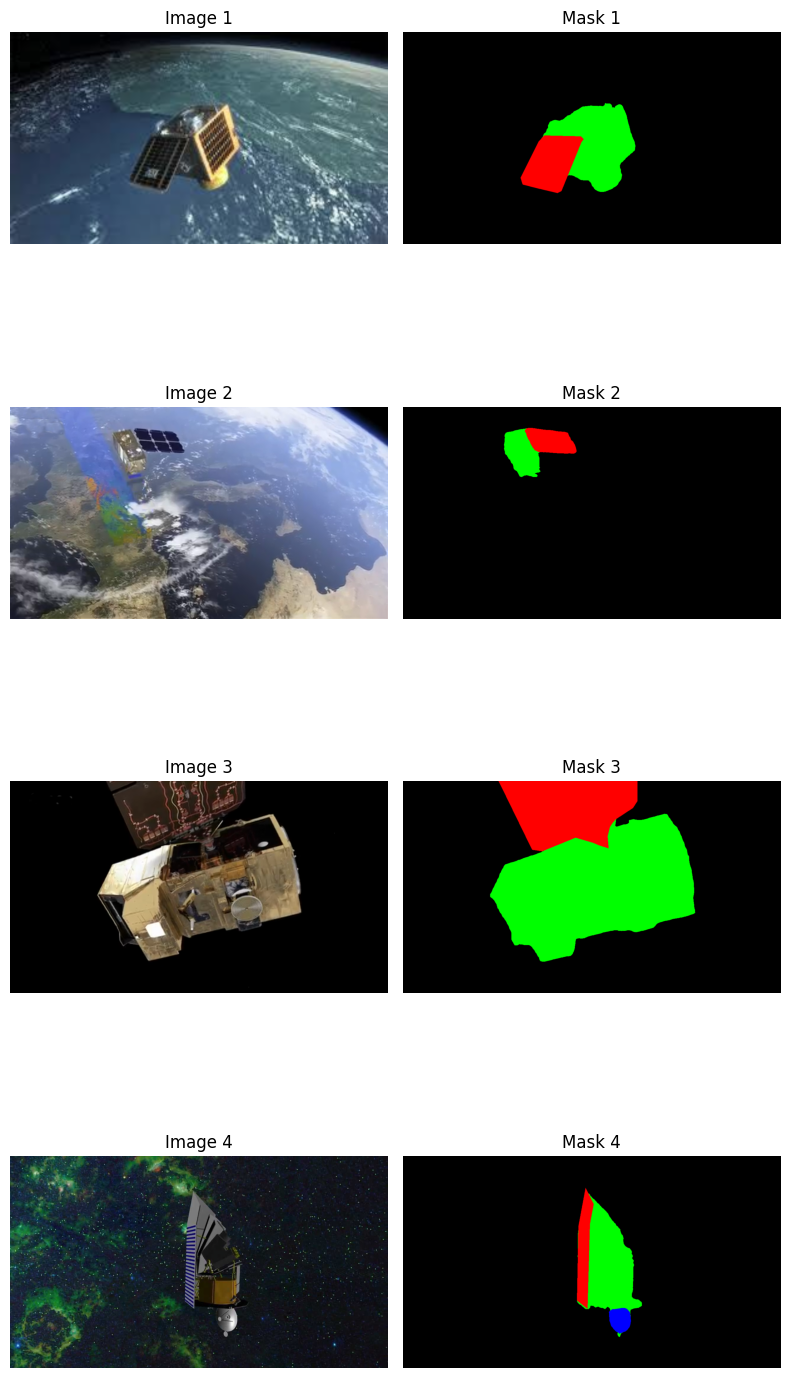

Validation dataset


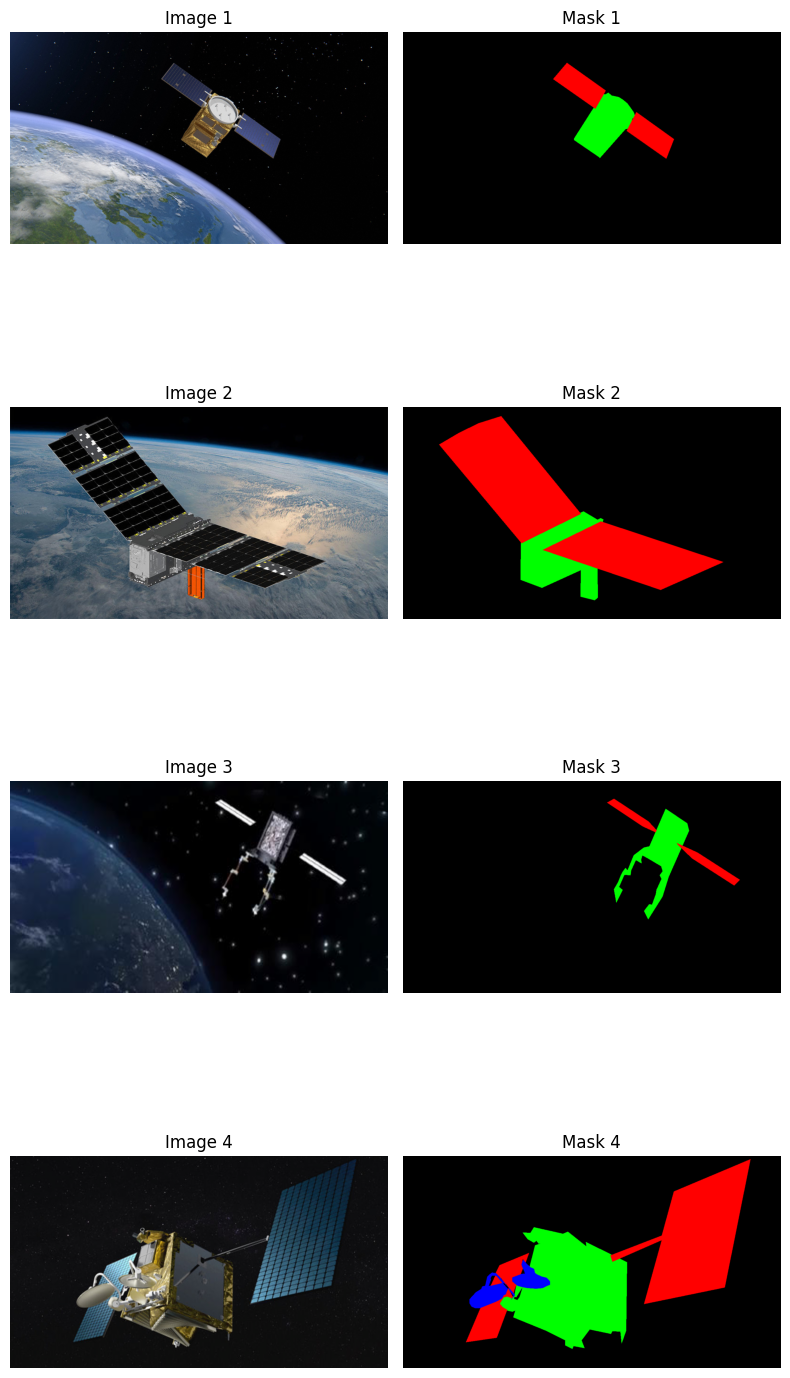

In [75]:
def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(4, 2, figsize=(8, 16))

    for i in range(num_samples):
        image, mask = dataset[i]
        
        # image is a tensor [C,H,W] normalized; denormalize for display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])

        image_np = image.permute(1, 2, 0).numpy()
        image_np = (image_np * std + mean).clip(0, 1)
        
        mask_np = mask.permute(1, 2, 0).numpy()
        
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(mask_np)
        axes[i, 1].set_title(f"Mask {i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

print("Training dataset")
plot_samples(dataset_train)
print("Validation dataset")
plot_samples(dataset_val)


### Выбираем аугментации для обучения

Вы можете заменить аугментацию на ваш выбор

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = SattDataset(
    "train",
    transform=train_transform,
)

val_transform = A.Compose(
    [
        A.Resize(512, 512)
    ]   A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = SattDataset("Val", transform=train_transform)

In [ ]:
display_few_examples_from_data(train_dataset)
print("Validation dataset")
display_few_examples_from_data(val_dataset)

## Обучение модели

 
1.   Реализуйте выбранную вами модели instance segmentation
2.   Обучите модель
3.   Сравните разные метрики instance segmentation, включая mIoU

